In [1]:
import time
import sys
import logging
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from imutils import face_utils
from pyqtgraph.Qt import QtGui, QtCore
import pyqtgraph as pg
from face_utilities import Face_utilities
from signal_processing import Signal_processing

logging.basicConfig(level=logging.INFO)

In [2]:
data = pd.read_csv("assets/data.csv", index_col='N')
data['HR_predicted'] = np.NaN

for index, row in data.iterrows():
    if pd.isna(row['Recording']):
        continue
    #if index<16:
    #    continue
    #cap = cv2.VideoCapture("assets/video_3.mp4")
    logging.info('-'*50)
    logging.info(f"\nReading video {index} ({row['Recording']})")
    cap = cv2.VideoCapture(f"assets/video/{row['Recording']}.mp4")

    
    fu = Face_utilities()
    sp = Signal_processing()
    
    i=0
    
    
    t = time.time()
    
    #for signal_processing
    BUFFER_SIZE = 100
    
    fps=0 #for real time capture
    video_fps = cap.get(cv2.CAP_PROP_FPS) # for video capture
    #print(video_fps)
    
    times: list = []  # size: 1 x BUFFER_SIZE
    data_buffer: list = []  # size: 1 x BUFFER_SIZE
    data_buffer_all: list = []  # size: 1 x videoFrames
    filtered_data = []  # size: 1 x BUFFER_SIZE
    fft_of_interest = []
    freqs_of_interest = []
    
    bpm = 0
    bpm_all = []  # size: 1 x videoFrames
    
    
    
    while True:
        # grab a frame -> face detection -> crop the face -> 68 facial landmarks -> get mask from those landmarks
        t0 = time.time()    
        ret, frame = cap.read()
        
        if frame is None:
            break
        
        ret_process = fu.no_age_gender_face_process(frame, "68")
        
        if ret_process is None:
            logging.warning("No face detected")
            continue
        
        rects, face, shape, aligned_face, aligned_shape = ret_process
        
        (x, y, w, h) = face_utils.rect_to_bb(rects[0])
        cv2.rectangle(frame,(x,y),(x+w,y+h),(0,0,255),2)

        if(len(aligned_shape)==68):
            cv2.rectangle(aligned_face,(aligned_shape[54][0], aligned_shape[29][1]), #draw rectangle on right and left cheeks
                    (aligned_shape[12][0],aligned_shape[33][1]), (0,255,0), 0)
            cv2.rectangle(aligned_face, (aligned_shape[4][0], aligned_shape[29][1]), 
                    (aligned_shape[48][0],aligned_shape[33][1]), (0,255,0), 0)
        else:
            cv2.rectangle(aligned_face, (aligned_shape[0][0],int((aligned_shape[4][1] + aligned_shape[2][1])/2)),
                        (aligned_shape[1][0],aligned_shape[4][1]), (0,255,0), 0)
            
            cv2.rectangle(aligned_face, (aligned_shape[2][0],int((aligned_shape[4][1] + aligned_shape[2][1])/2)),
                        (aligned_shape[3][0],aligned_shape[4][1]), (0,255,0), 0)
        
        for (x, y) in aligned_shape: 
            cv2.circle(aligned_face, (x, y), 1, (0, 0, 255), -1)
            
            
        #for signal_processing
        ROIs = fu.ROI_extraction(aligned_face, aligned_shape)
        green_val = sp.extract_color(ROIs)
        logging.debug(green_val)
        
        data_buffer.append(green_val)
        data_buffer_all.append(green_val)
        
        times.append((1.0/video_fps)*i)
        
        L = len(data_buffer)
        if L <= BUFFER_SIZE:
            cv2.putText(frame, "Filling up buffer...", (30,int(frame.shape[0]*0.95)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
        else:
            data_buffer = data_buffer[-BUFFER_SIZE:]
            times = times[-BUFFER_SIZE:]
            fps = float(BUFFER_SIZE) / (times[-1] - times[0])
            cv2.putText(frame, "fps: {0:.2f}".format(fps), (30,int(frame.shape[0]*0.85)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
            detrended_data = sp.signal_detrending(data_buffer)
            interpolated_data = sp.interpolation(detrended_data, times)
            normalized_data = sp.normalization(interpolated_data)
            
            fft_of_interest, freqs_of_interest = sp.fft(normalized_data, fps)
            max_arg = np.argmax(fft_of_interest)
            bpm = freqs_of_interest[max_arg]
            cv2.putText(frame, "HR_real: {0:.2f}".format(row['HR']), (30,int(frame.shape[0]*0.90)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
            cv2.putText(frame, "HR_predicted: {0:.2f}".format(bpm), (30,int(frame.shape[0]*0.95)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
            filtered_data = sp.butter_bandpass_filter(interpolated_data, (bpm-20)/60, (bpm+20)/60, fps, order = 3)
            
        bpm_all.append(bpm)
    
        # display
        cv2.imshow("frame",frame)
        cv2.imshow("face",aligned_face)
        i = i+1
        logging.debug("time of the loop number "+ str(i) +" : " + str(time.time()-t0))
        
        # waitKey to show the frame and break loop whenever 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

    assert len(data_buffer) == 100
    assert len(bpm_all) == len(data_buffer_all)
    logging.info("End of video. Total running time: " + str(time.time() - t))
    logging.info(f"We should have about {int(video_fps*30)} frames, and we have {len(bpm_all)}")
    logging.info(f"Final BPM: {int(bpm_all[-1])}")
    logging.info(f"Average BPM: {int(np.mean(bpm_all[BUFFER_SIZE:]))}")
    logging.info(f"Real BPM: {row['HR']}")

    data.loc[index, 'HR_predicted'] = int(np.mean(bpm_all[BUFFER_SIZE:]))


INFO:root:--------------------------------------------------
INFO:root:
Reading video 1 (15:50:04)
INFO:root:End of video. Total running time: 45.579970836639404
INFO:root:We should have about 900 frames, and we have 860
INFO:root:Final BPM: 145
INFO:root:Average BPM: 69
INFO:root:Real BPM: 100.0
INFO:root:--------------------------------------------------
INFO:root:
Reading video 2 (15:53:33)
INFO:root:End of video. Total running time: 47.307955503463745
INFO:root:We should have about 900 frames, and we have 905
INFO:root:Final BPM: 72
INFO:root:Average BPM: 67
INFO:root:Real BPM: 101.0
INFO:root:--------------------------------------------------
INFO:root:
Reading video 6 (15:55:30)
INFO:root:End of video. Total running time: 49.89273166656494
INFO:root:We should have about 900 frames, and we have 903
INFO:root:Final BPM: 54
INFO:root:Average BPM: 79
INFO:root:Real BPM: 129.0
INFO:root:--------------------------------------------------
INFO:root:
Reading video 7 (15:58:54)
INFO:root:

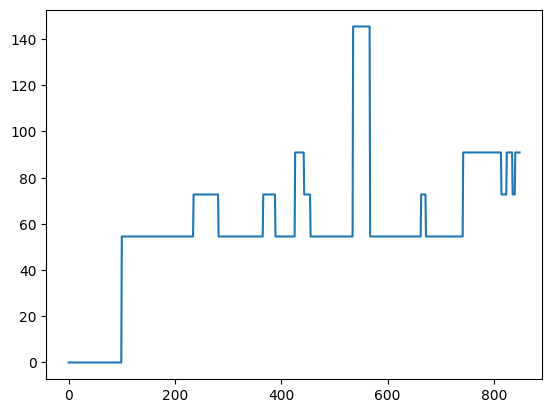

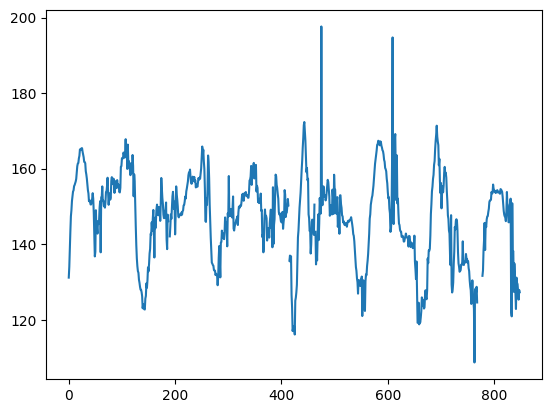

In [5]:
plt.plot(bpm_all)
plt.show()
plt.plot(data_buffer_all)